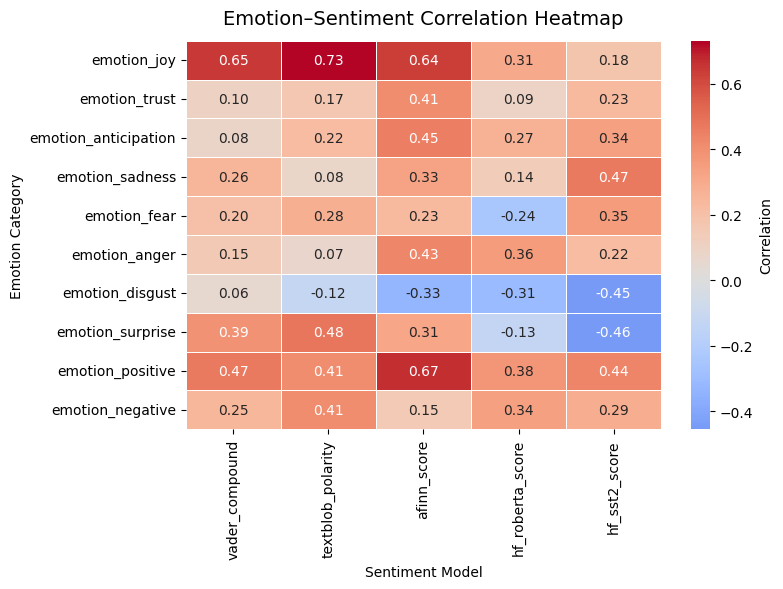

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../data/rejection_analysis_extended.csv')

# Exclude ghosted emails
df = df[df['status'] != 'ghosted']

# Emotion and sentiment columns
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
sentiment_cols = ['vader_compound', 'textblob_polarity', 'afinn_score',
                  'hf_roberta_score', 'hf_sst2_score']

# Correlation matrix
corr = df[emotion_cols + sentiment_cols].corr()[sentiment_cols].loc[emotion_cols]

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr, 
    annot=True, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=0.5, cbar_kws={'label': 'Correlation'}
)
plt.title("Emotion–Sentiment Correlation Heatmap", fontsize=14, pad=12)
plt.xlabel("Sentiment Model")
plt.ylabel("Emotion Category")
plt.tight_layout()

# Save and show
plt.savefig('../visualizations/emotion_sentiment_heatmap.png', dpi=300)
plt.show()



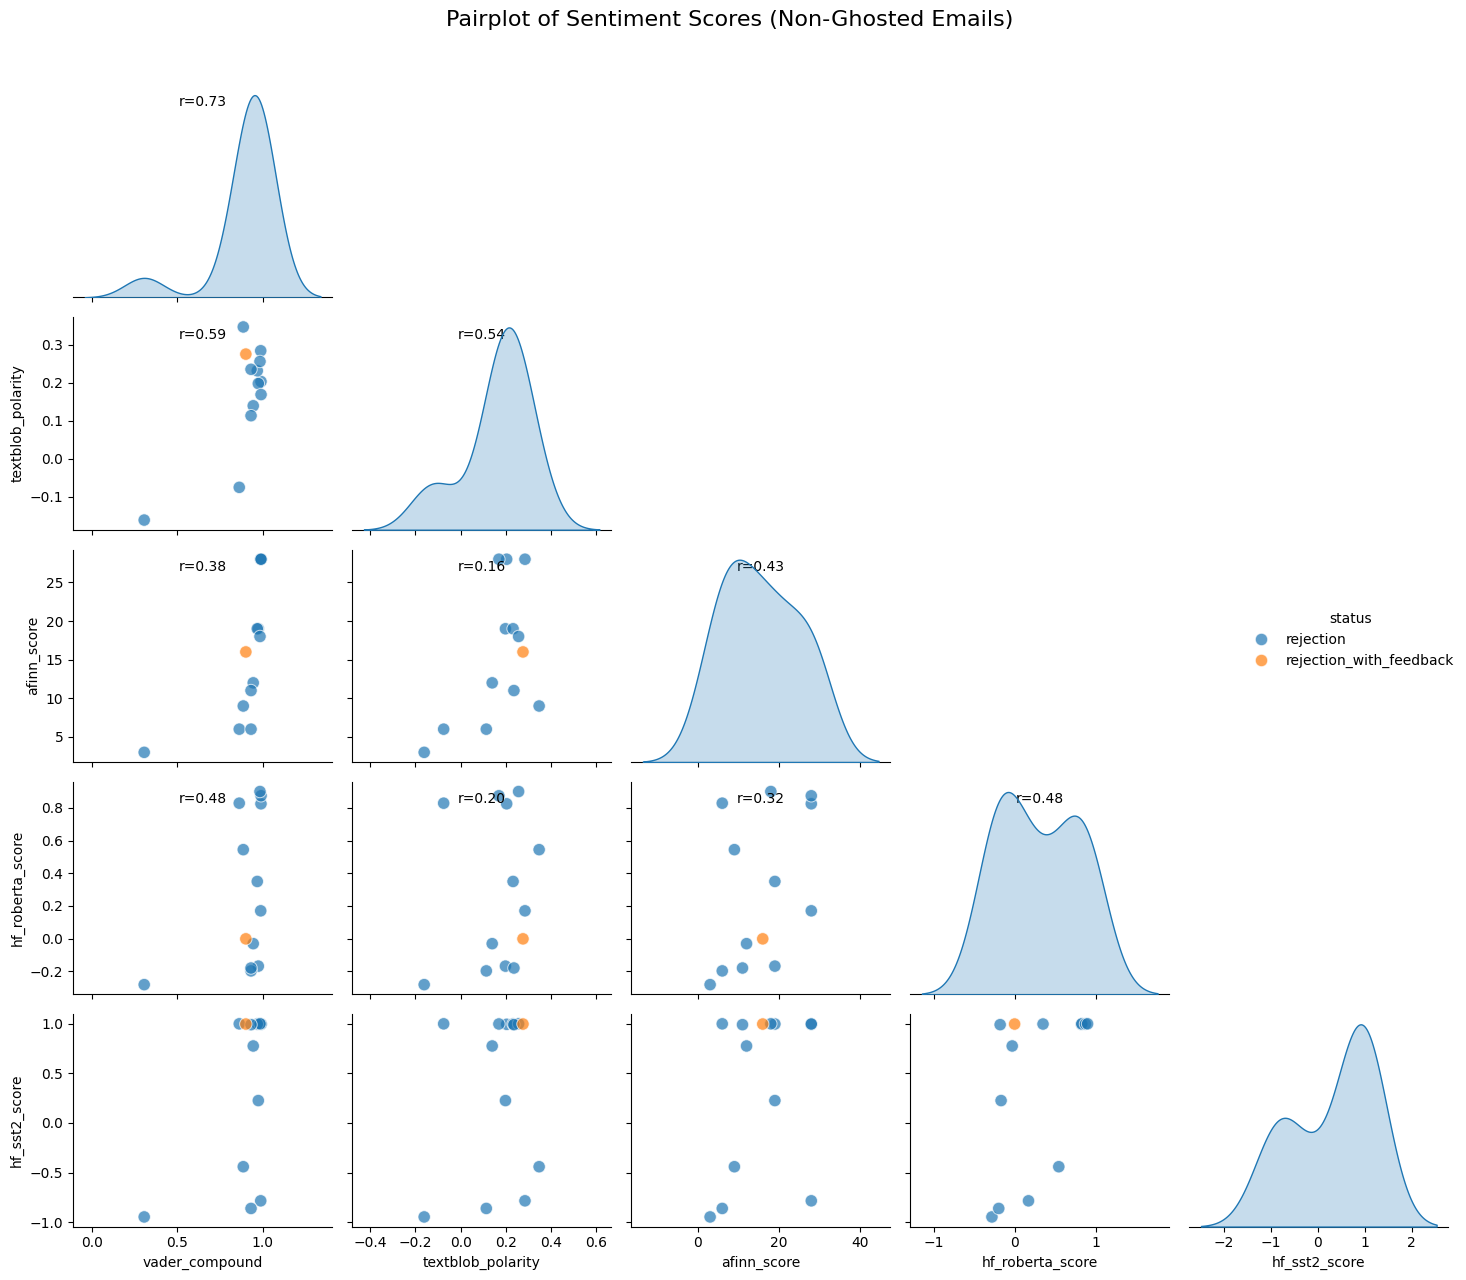

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load CSV
df = pd.read_csv('../data/rejection_analysis_extended.csv')

# Exclude ghosted applications
df = df[df['status'] != 'ghosted']

# Sentiment columns
sentiment_cols = ['vader_compound', 'textblob_polarity', 'afinn_score',
                  'hf_roberta_score', 'hf_sst2_score']

# Subset the data
df_sentiment = df[sentiment_cols + ['status']]

# Pairplot with hue
pairplot = sns.pairplot(df_sentiment, hue='status', corner=True,
                        plot_kws={'alpha':0.7, 's':80})

# Annotate correlation on the upper triangle (adjusted for corner)
num_vars = len(sentiment_cols)
for i in range(num_vars):
    for j in range(i+1, num_vars):
        ax = pairplot.axes[j-1, i]  # row=j-1, col=i in corner=True
        if ax is not None:
            corr_val = np.corrcoef(df_sentiment[sentiment_cols[i]],
                                    df_sentiment[sentiment_cols[j]])[0,1]
            ax.annotate(f"r={corr_val:.2f}", xy=(0.5,0.9), xycoords='axes fraction',
                        ha='center', fontsize=10, color='black')

# Adjust and save
plt.suptitle("Pairplot of Sentiment Scores (Non-Ghosted Emails)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../visualizations/sentiment_pairplot.png', dpi=300)
plt.show()




In [15]:
df_transformer = df[df['status'] != 'ghosted']


print("RoBERTa scores:")
print(df_transformer['hf_roberta_score'].describe())

print("\nSST-2 scores:")
print(df_transformer['hf_sst2_score'].describe())


RoBERTa scores:
count    13.000000
mean      0.279556
std       0.461498
min      -0.281681
25%      -0.168369
50%       0.170246
75%       0.825332
max       0.900407
Name: hf_roberta_score, dtype: float64

SST-2 scores:
count    13.000000
mean      0.380296
std       0.825117
min      -0.946643
25%      -0.440683
50%       0.990662
75%       0.997080
max       0.999254
Name: hf_sst2_score, dtype: float64


In [16]:
transformer_cols = ['hf_roberta_score', 'hf_sst2_score']
lexicon_cols = ['vader_compound', 'textblob_polarity', 'afinn_score']

for t_col in transformer_cols:
    for l_col in lexicon_cols:
        corr_val = df_transformer[t_col].corr(df_transformer[l_col])
        print(f"{t_col} vs {l_col}: r = {corr_val:.2f}")


hf_roberta_score vs vader_compound: r = 0.38
hf_roberta_score vs textblob_polarity: r = 0.16
hf_roberta_score vs afinn_score: r = 0.43
hf_sst2_score vs vader_compound: r = 0.48
hf_sst2_score vs textblob_polarity: r = 0.20
hf_sst2_score vs afinn_score: r = 0.32


In [18]:
import pandas as pd
import numpy as np

# Load extended CSV
df = pd.read_csv('../data/rejection_analysis_extended.csv')

# Exclude ghosted emails
df = df[df['status'] != 'ghosted'].copy()

# Normalize AFINN score to roughly [-1, 1] for comparison
afinn_max_abs = df['afinn_score'].abs().max()
df['afinn_score_norm'] = df['afinn_score'] / afinn_max_abs if afinn_max_abs != 0 else df['afinn_score']

# Compute average lexicon score
df['lexicon_avg'] = df[['vader_compound', 'textblob_polarity', 'afinn_score_norm']].mean(axis=1)

# Compute max disagreement vs transformers
df['max_disagreement_roberta'] = (df['lexicon_avg'] - df['hf_roberta_score']).abs()
df['max_disagreement_sst2'] = (df['lexicon_avg'] - df['hf_sst2_score']).abs()
df['max_disagreement'] = df[['max_disagreement_roberta', 'max_disagreement_sst2']].max(axis=1)

# Optional: add a note on which transformer disagrees most
def disagreement_note(row):
    if row['max_disagreement'] == row['max_disagreement_roberta']:
        return 'RoBERTa disagrees most'
    else:
        return 'SST-2 disagrees most'

df['note'] = df.apply(disagreement_note, axis=1)

# Select relevant columns for comparison table
cols = ['company_id', 'email_text', 'vader_compound', 'textblob_polarity', 
        'afinn_score', 'hf_roberta_score', 'hf_sst2_score', 'max_disagreement', 'note']
comparison_table = df[cols].sort_values(by='max_disagreement', ascending=False)

# Save to CSV
comparison_table.to_csv('../data/sentiment_disagreement_highlights.csv', index=False)

# Display top 5 largest disagreements
print("Top 5 emails with biggest disagreement between lexicon vs Transformer models:")
print(comparison_table.head(5))


Top 5 emails with biggest disagreement between lexicon vs Transformer models:
   company_id                                         email_text  \
1   Company_B  Hello, Thank you for your interest in joining ...   
9   Company_J  Hi [Name], First of all my apologies for not g...   
3   Company_D  Hi [Name], Thanks for taking the time to apply...   
10  Company_K  Hi [Name], Thank you for your interest in our ...   
2   Company_C  Hi [Name], Thanks for your application with [C...   

    vader_compound  textblob_polarity  afinn_score  hf_roberta_score  \
1           0.9878           0.284615         28.0          0.170246   
9           0.9313           0.113636          6.0         -0.197509   
3           0.3071          -0.161111          3.0         -0.281681   
10          0.8860           0.347273          9.0          0.544591   
2           0.9739           0.198214         19.0         -0.168369   

    hf_sst2_score  max_disagreement                    note  
1       -0.784227 

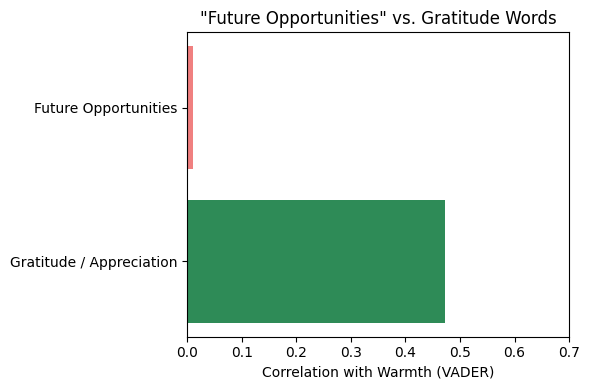

<Figure size 640x480 with 0 Axes>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/rejection_analysis_extended.csv')

keywords = ['future_keywords', 'empathy_words']  # you could expand to individual words if desired
correlations = [
    df['mentions_future'].corr(df['vader_compound']),
    df['empathy_words'].corr(df['vader_compound'])
]

words = ['Future Opportunities', 'Gratitude / Appreciation']
colors = ['lightcoral' if x < 0.2 else 'seagreen' for x in correlations]

plt.figure(figsize=(6,4))
plt.barh(words, correlations, color=colors)
plt.xlabel("Correlation with Warmth (VADER)")
plt.xlim(0, 0.7)
plt.gca().invert_yaxis()
plt.title('"Future Opportunities" vs. Gratitude Words')
plt.tight_layout()
plt.show()
plt.savefig('../visualizations/future_vs_gratitude.png', dpi=300)


/var/folders/6k/0qvxrpnd0rd_bcv5419k929r0000gn/T/ipykernel_3782/250598615.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(agg['company_id'], rotation=30, ha='right')


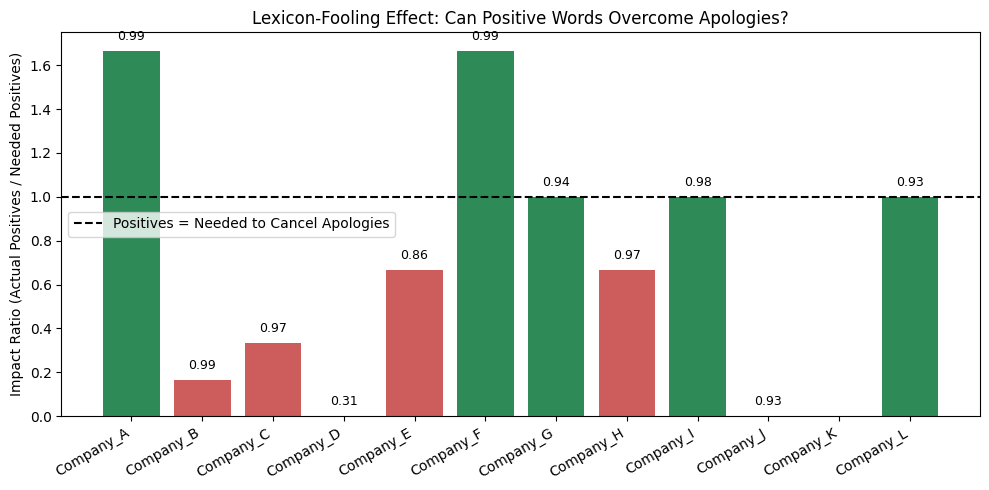

<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load processed data
df = pd.read_csv('../data/rejection_analysis_extended.csv')

# Aggregate by company
agg = df.groupby('company_id').agg({
    'apology_words': 'sum',
    'empathy_words': 'sum',
    'vader_compound': 'mean'
}).reset_index()

# Compute “impact ratio”: actual positives ÷ positives needed to cancel apologies
agg['required_positive_to_cancel'] = agg['apology_words'] * 3
agg['impact_ratio'] = agg['empathy_words'] / agg['required_positive_to_cancel']

# Plot
fig, ax = plt.subplots(figsize=(10,5))
colors = agg['impact_ratio'].apply(lambda x: 'seagreen' if x >= 1 else 'indianred')
ax.bar(agg['company_id'], agg['impact_ratio'], color=colors)
ax.set_xticklabels(agg['company_id'], rotation=30, ha='right')
# Annotate VADER score
for i, row in agg.iterrows():
    ax.text(i, row['impact_ratio'] + 0.05, f"{row['vader_compound']:.2f}", ha='center', fontsize=9)

ax.axhline(1, color='black', linestyle='--', label='Positives = Needed to Cancel Apologies')
ax.set_ylabel('Impact Ratio (Actual Positives / Needed Positives)')
ax.set_title('Lexicon-Fooling Effect: Can Positive Words Overcome Apologies?')
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig('../visualizations/positive_overcome.png', dpi=300)


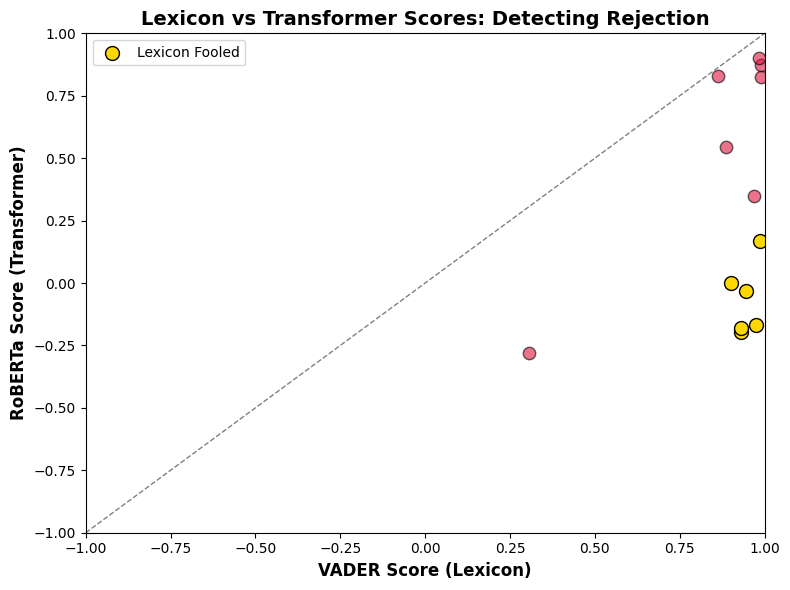

In [23]:

# Filter out ghosted applications if desired
df_plot = df[df['status'] != 'ghosted']

# Scatter plot: Lexicon (VADER) vs Transformer (RoBERTa)
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['vader_compound'], df_plot['hf_roberta_score'],
            c='crimson', alpha=0.6, edgecolors='k', s=80)

# Diagonal line for reference (y=x)
lims = [-1, 1]
plt.plot(lims, lims, '--', color='gray', linewidth=1)

plt.xlabel("VADER Score (Lexicon)", fontsize=12, fontweight='bold')
plt.ylabel("RoBERTa Score (Transformer)", fontsize=12, fontweight='bold')
plt.title("Lexicon vs Transformer Scores: Detecting Rejection", fontsize=14, fontweight='bold')
plt.xlim(lims)
plt.ylim(lims)


threshold_lexicon = 0.5 
threshold_transformer = 0.2  
fooled = df_plot[(df_plot['vader_compound'] > threshold_lexicon) &
                 (df_plot['hf_roberta_score'] < threshold_transformer)]

plt.scatter(fooled['vader_compound'], fooled['hf_roberta_score'],
            c='gold', edgecolors='k', s=100, label='Lexicon Fooled')

plt.legend()
plt.tight_layout()
plt.savefig("../visualizations/lexicon_vs_transformer.png", dpi=300)
plt.show()


In [24]:
# Filter the email
email_row = df[df['company_id'] == 'Company_B'].iloc[0]
text = email_row['email_text']

# VADER score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader_scores = vader.polarity_scores(text)
print("VADER scores:", vader_scores)

# Count positive/negative words (approximate)
words = text.lower().split()
positive_words = [w for w in words if vader.lexicon.get(w, 0) > 0]
negative_words = [w for w in words if vader.lexicon.get(w, 0) < 0]
print(f"Positive words: {len(positive_words)} → {positive_words}")
print(f"Negative words: {len(negative_words)} → {negative_words}")

# RoBERTa score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1).numpy()[0]

roberta_score = probs[2] - probs[0]  # positive - negative
print("RoBERTa score:", roberta_score)


VADER scores: {'neg': 0.056, 'neu': 0.681, 'pos': 0.263, 'compound': 0.9878}
Positive words: 14 → ['thank', 'interest', 'best', 'great', 'help', 'like', 'beautifully', 'highlight', 'matters', 'easily', 'better', 'good', 'luck', 'dream']
Negative words: 2 → ['mistakes', 'no']


/Users/chotij/Documents/Coding/job_rejection_analysis/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

RoBERTa score: 0.17024624
